<a href="https://colab.research.google.com/github/meetdelvadiya/Appliance-Energy-Prediction/blob/main/Appliance_Energy_Prediction_Project_Meet_Delvadiya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data-driven prediction of energy use of appliances**

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import dateutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# mounting drive
from google.colab import drive
 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset=pd.read_csv("/content/drive/MyDrive/Dataset/data_application_energy.csv")

In [4]:
dataset.shape

(19735, 29)

In [5]:
#It gives first 5 rows of dataset
dataset.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
#It gives last 5 rows of dataset
dataset.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [7]:
#It gives total columns, data types and null count of dataset.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [8]:
# table to return datatype,null and unique counnt
def printinfo():
    temp = pd.DataFrame(index=dataset.columns)
    temp['data_type'] = dataset.dtypes
    temp['null_count'] = dataset.isnull().sum()
    temp['unique_count'] = dataset.nunique()
    return temp

printinfo()

,data_type,null_count,unique_count
date,object,0,19735
Appliances,int64,0,92
lights,int64,0,8
T1,float64,0,722
RH_1,float64,0,2547
T2,float64,0,1650
RH_2,float64,0,3376
T3,float64,0,1426
RH_3,float64,0,2618
T4,float64,0,1390


As shown above , there are no null values in the dataset

In [9]:
dataset["exact_date"]=dataset['date'].str.split(' ').str[0]
dataset["days"]=(dataset['date'].str.split(' ').str[0])
dataset["days"]=(dataset['days'].apply(dateutil.parser.parse, dayfirst=True))
dataset["days"]=(dataset['days'].dt.day_name())

In [10]:
dataset['lights'].value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

There are many '0' values in 'lights' column so we will drop it. 
We are separating 'date' column into 'exact date' and 'days' so we will drop original 'date' column.



In [11]:
dataset.drop(['date','lights'],axis=1,inplace=True)

In [12]:
dataset.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,exact_date,days
0,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,2016-01-11,Tuesday
1,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,2016-01-11,Tuesday
2,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,2016-01-11,Tuesday
3,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,2016-01-11,Tuesday
4,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,2016-01-11,Tuesday


In [13]:
#It gives some basic statistical details like percentile, mean, std, max etc.
dataset.describe()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


Here, Appliances have mean value around 100 and minimum value is 10 whereas maximum is 1080. So we can ignore outliers.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Appliance consumption in Wh')]

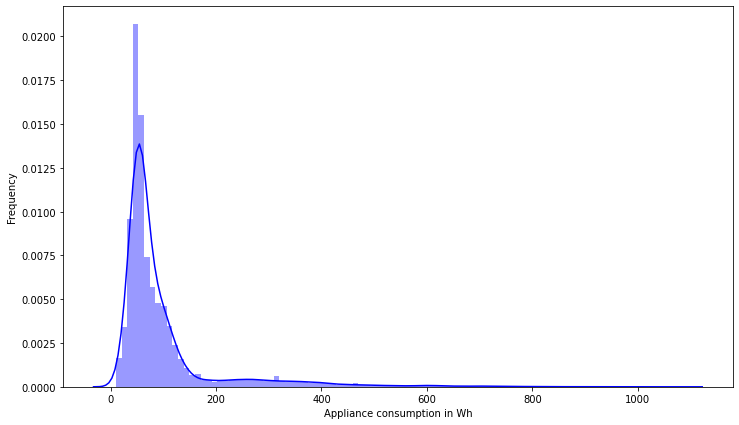

In [14]:
# Distribution of values in Applainces column
f = plt.figure(figsize=(12,7))
ax=sns.distplot(dataset['Appliances'],bins=100 ,color = 'blue')
ax.set(xlabel='Appliance consumption in Wh', ylabel='Frequency')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Appliances log(wH)')

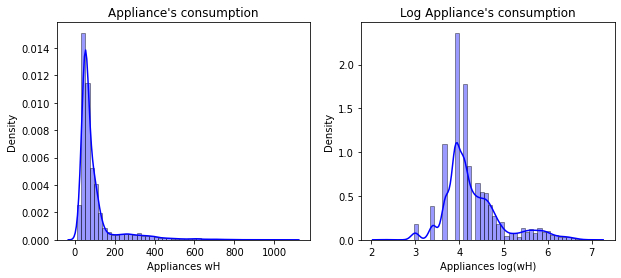

In [15]:
f, axes = plt.subplots(1, 2,figsize=(10,4))
sns.distplot((dataset['Appliances'] ), hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[0])
axes[0].set_title("Appliance's consumption")
axes[0].set_xlabel('Appliances wH')

sns.distplot((np.log(dataset['Appliances'])), hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[1])
axes[1].set_title("Log Appliance's consumption")
axes[1].set_xlabel('Appliances log(wH)')

In [16]:
print(dataset['Appliances'].mean())

97.6949581960983


Here, Appliances usage mean value is 97.69, So we are calculating Percentage of the Appliance Consumption which are less than 100 Wh(nearby 97.69).


In [17]:
print('Percentage of the appliance consumption less than 100 Wh')
print(((dataset['Appliances'][dataset['Appliances'] <= 100].count()) / (len(dataset['Appliances'])))*100 )

Percentage of the appliance consumption less than 100 Wh
78.55079807448695


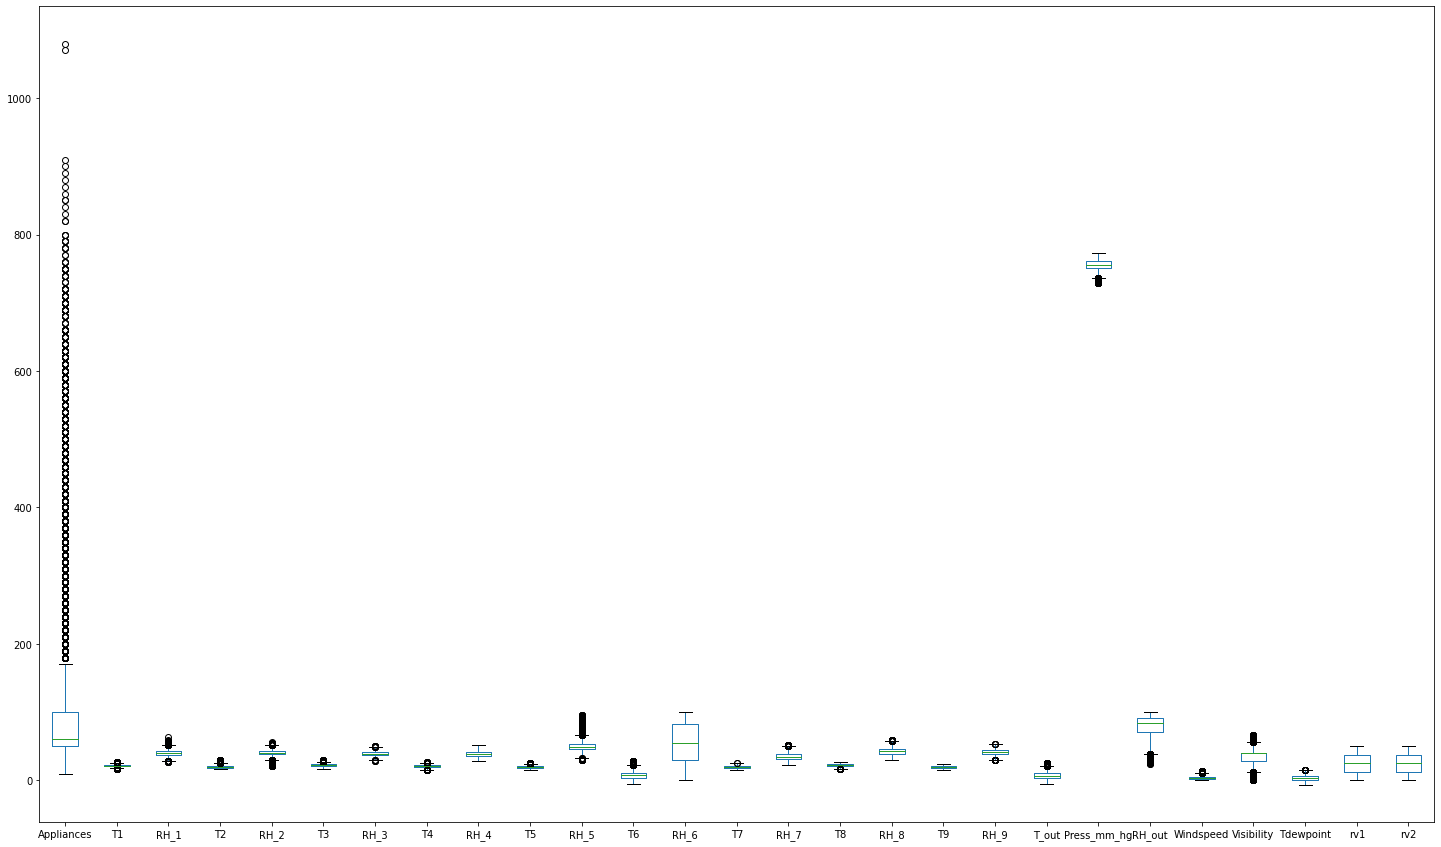

In [18]:
dataset.plot.box(figsize=(25, 15))

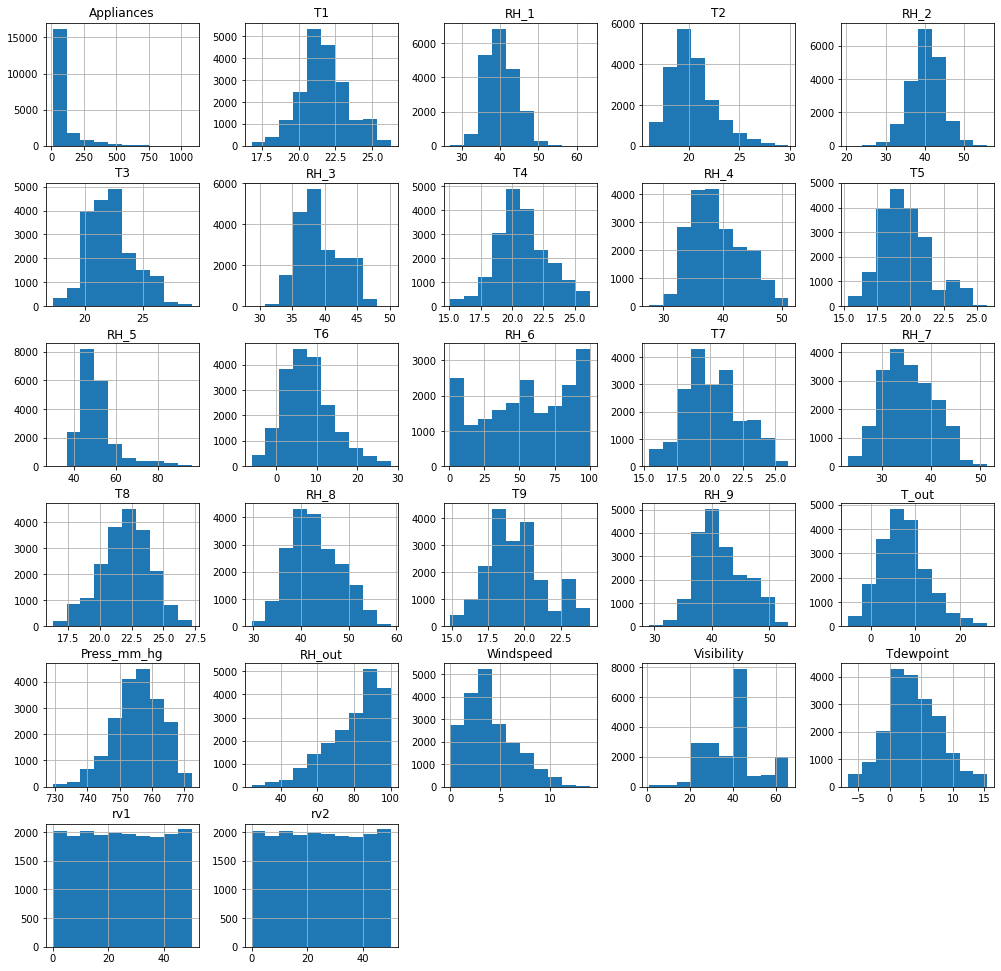

In [19]:
# Histogram of all the features
dataset.hist(figsize= (17,17)) ;

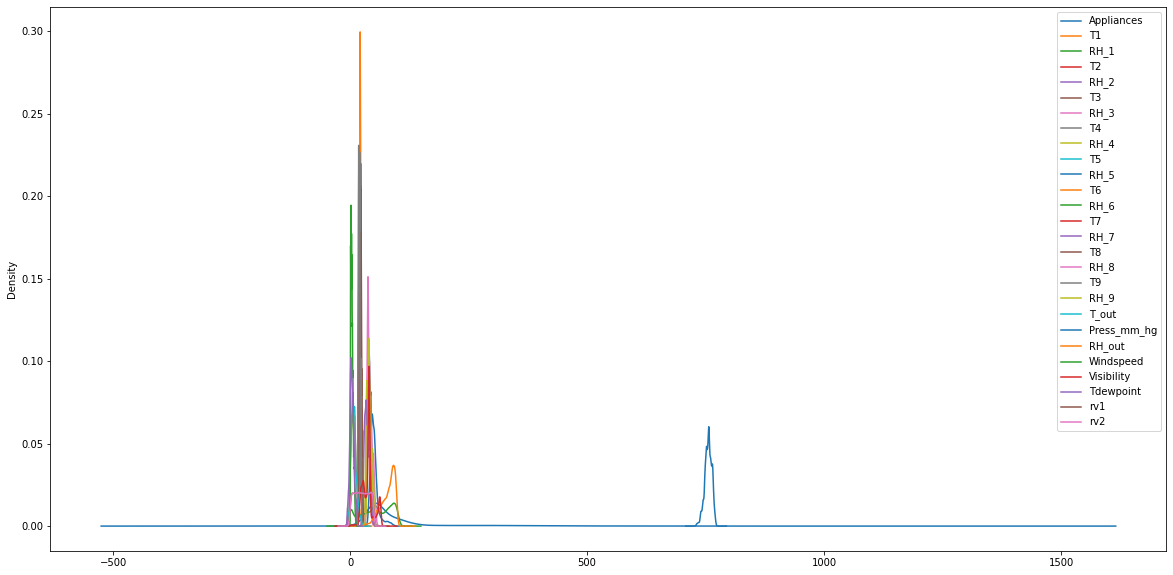

In [20]:
dataset.plot(kind = 'density',figsize= (20,10))

In [22]:
dates=dataset["exact_date"].unique()
arranged_day = pd.Categorical(dataset["exact_date"], categories=dates,ordered=True)
date_series = pd.Series(arranged_day)
days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday","Saturday","Sunday"]
day_series = pd.Series(arranged_day)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


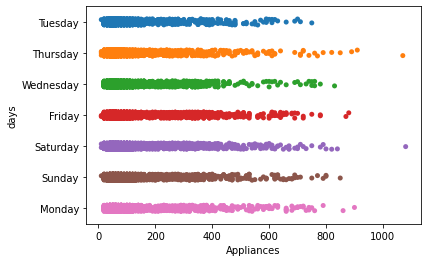

In [23]:
plt.figure()
sns.stripplot(dataset['Appliances'], "days", data = dataset)

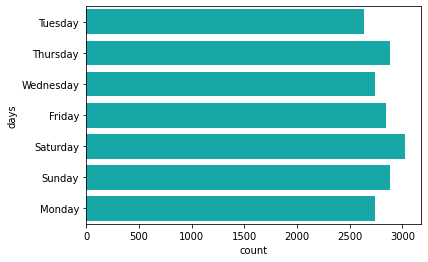

In [24]:
plt.figure()
sns.countplot(y = "days", data = dataset, color = "c")

In [25]:
dataset.skew()

Appliances     3.386367
T1             0.120917
RH_1           0.465774
T2             0.889658
RH_2          -0.268247
T3             0.450777
RH_3           0.467589
T4             0.170384
RH_4           0.444614
T5             0.558220
RH_5           1.866820
T6             0.597471
RH_6          -0.241961
T7             0.254722
RH_7           0.242141
T8            -0.256151
RH_8           0.308036
T9             0.382711
RH_9           0.368937
T_out          0.534273
Press_mm_hg   -0.420442
RH_out        -0.922997
Windspeed      0.859982
Visibility     0.441554
Tdewpoint      0.239374
rv1            0.004945
rv2            0.004945
dtype: float64